**Emilia Stefanowska, 2022**

## Generowanie dyktand melodycznych - silnik aplikacji
*Generating melodic dictations - application engine*

In [1]:
import os
import pickle
from music21 import converter, chord, note, key, interval, pitch, stream
# import numpy as np
from keras.utils import np_utils
from keras.layers import LSTM, Input, Dropout, Reshape, Dense, Activation, RepeatVector, Embedding, Concatenate, Bidirectional, Lambda, Permute, Multiply, Flatten
from keras.models import Model
import keras.backend as K 
from keras.optimizers import RMSprop
from keras.utils import plot_model
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from datetime import datetime
import statistics
import math

Using TensorFlow backend.


**Ustawianie parametrów i folderu z zapisem danych** <br>
*Setting the parameters and backup folders*

In [2]:
# Model parameters
seq_len = 10
embedding_size = 125
rnn_units = 315

In [3]:
# Preparing backup folders
date = str(datetime.now().strftime("%m-%d-%Y_%H-%M"))
name = "seq-{}_emb-{}_rnn-{}".format(seq_len, embedding_size, rnn_units)
training_id = '3-4_with-attention_{date}-{name}'.format(date=date, name=name)

attention = True

source_folder = 'D:/Studia/Praca_inzynierska/Baza_dyktanda/Lasocki_solfez/4-4/MIDI/'
# source_folder = 'D:/Studia/Praca_inzynierska/Baza_dyktanda/Lasocki_solfez/3-4/MIDI/'

backup_folder = 'backup/{}/'.format(training_id)
files = os.listdir(source_folder)

# Creating backup folder if doesn't already exist
if not os.path.exists('backup'):
    os.mkdir('backup')

# Creating backup folder for this specific training session
if not os.path.exists(backup_folder):
    os.mkdir(backup_folder)
    os.mkdir(os.path.join(backup_folder, 'training_set_backup'))
    os.mkdir(os.path.join(backup_folder, 'model'))
    
backup_training_set_folder = os.path.join(backup_folder, 'training_set_backup')
model_folder = os.path.join(backup_folder, 'model')

print('%s training set files in total' % len(files))

315 training set files in total


**Przygotowanie zmiennych** <br>
*Preparing variables*

In [4]:
pitch_read = [] # training set pitch matrix - music21 names
rhythm_read = [] # training set rhythm matrix - music21 names

pitch_input = []
pitch_output = []
rhythm_input = []
rhythm_output = []

pitch_input_encoded = []
pitch_output_encoded = []
rhythm_input_encoded = []
rhythm_output_encoded = []

all_lengths = []
all_rhythms = []

**Odczytywanie i zapisywanie informacji ze zbioru treningowego** <br>
*Reading and saving data from the training set*

In [5]:
for file in files:
    pitch_this_file = []
    rhythm_this_file = []

    dictation = converter.parse(source_folder + file)
        
    # Transpose to C-major
    dictation_key_signature = dictation.analyze('key')
    
    if dictation_key_signature != key.Key('C'):
        i = interval.Interval(dictation_key_signature.tonic, pitch.Pitch('C'))
        dictation = dictation.transpose(i)
            
    # Adding start symbols to mark beginning of the piece
    pitch_this_file.extend(['S'] * seq_len)
    rhythm_this_file.extend([0.0] * seq_len)
        
    part_stream = dictation.parts.stream()
    my_part = part_stream[0] # ensuring we will use only the top melody IF we had multi-melody training set pieces
        
    for element in my_part.flat.notesAndRests:
        if element.isNote:
            pitch_this_file.append(str(element.nameWithOctave))
            rhythm_this_file.append(element.duration.quarterLength)

        if element.isRest:
            pitch_this_file.append(str(element.name))  # 'rest'
            rhythm_this_file.append(element.duration.quarterLength)
                
        if isinstance(element, chord.Chord): # if chord insert only the highest note
            pitch_this_file.append(element.pitches[-1].nameWithOctave)
            rhythm_this_file.append(element.duration.quarterLength)

        # Adding notes to an array of all the notes
        pitch_read.extend(pitch_this_file)     
        rhythm_read.extend(rhythm_this_file)
            
        
    file_length_in_notes = len(my_part.flat.notesAndRests)
    all_lengths.append(file_length_in_notes)
    length_in_bars = math.ceil((0.25 *round (sum(rhythm_this_file) /0.25))/3.0)
    all_rhythms.append(length_in_bars)
        
    # Creating sequences
    for i in range(file_length_in_notes):
        pitch_input.append(pitch_this_file[i : i + seq_len])
        pitch_output.append(pitch_this_file[i + seq_len])
        rhythm_input.append(rhythm_this_file[i : i + seq_len])
        rhythm_output.append(rhythm_this_file[i + seq_len])

# Create dictionaries with unique pitch and rhythm values
pitch_sorted = sorted(set(pitch_read))
pitch_dict = dict((number, pitch) for pitch, number in enumerate(pitch_sorted))
pitch_dict_reversed = dict((pitch, number) for pitch, number in enumerate(pitch_sorted))
    
rhythm_sorted = sorted(set(rhythm_read))
rhythm_dict = dict((number, rhythm) for rhythm, number in enumerate(rhythm_sorted))
rhythm_dict_reversed = dict((rhythm, number) for rhythm, number in enumerate(rhythm_sorted))

dict_tables = [pitch_sorted, pitch_dict, rhythm_sorted, rhythm_dict, pitch_dict_reversed, rhythm_dict_reversed]

# Saving training set pitch and rhythm matrices into binary files
with open(os.path.join(backup_training_set_folder, 'pitch'), 'wb') as file:
    pickle.dump(pitch_input, file)
with open(os.path.join(backup_training_set_folder, 'rhythm'), 'wb') as file:
    pickle.dump(rhythm_input, file)
with open(os.path.join(backup_training_set_folder, 'dictionaries'), 'wb') as file:
    pickle.dump(dict_tables, file)

**Statystyki dotyczące ilości nut i taktów w dyktandach treningowych** <br>
*Stats about number of notes and bars in training dictations*

In [6]:
print("Statystyki odnośnie ilości taktów")
print("Średnia: \t{}".format(statistics.mean(all_rhythms)))
print("Dominanta: \t{}".format(statistics.mode(all_rhythms)))
print("Mediana: \t{}".format(statistics.median(all_rhythms)))
print("Minimum: \t{}".format(min(all_rhythms)))
print("Maksimum: \t{}".format(max(all_rhythms)))

print("\nStatystyki odnośnie ilości nut")
print("Średnia: \t{}".format(statistics.mean(all_lengths)))
print("Dominanta: \t{}".format(statistics.mode(all_lengths)))
print("Mediana: \t{}".format(statistics.median(all_lengths)))
print("Minimum: \t{}".format(min(all_lengths)))
print("Maksimum: \t{}".format(max(all_lengths)))

Statystyki odnośnie ilości taktów
Średnia: 	12.2984126984127
Dominanta: 	11
Mediana: 	11
Minimum: 	4
Maksimum: 	48

Statystyki odnośnie ilości nut
Średnia: 	45.66984126984127
Dominanta: 	31
Mediana: 	39
Minimum: 	14
Maksimum: 	143


**Przygotowywanie danych do sieci neuronowej** <br>
*Preparing data for neural network*

In [7]:
for i in range(len(pitch_input)):
    pitch_input_encoded.append([pitch_dict[pitch_name] for pitch_name in pitch_input[i]])
    pitch_output_encoded.append(pitch_dict[pitch_output[i]])
    rhythm_input_encoded.append([rhythm_dict[rhythm_name] for rhythm_name in rhythm_input[i]])
    rhythm_output_encoded.append(rhythm_dict[rhythm_output[i]])
    
# output of the network - one-hot encoding *kodowanie 1 z n*
pitch_output_encoded = np_utils.to_categorical(pitch_output_encoded, num_classes=len(pitch_dict)) 
rhythm_output_encoded = np_utils.to_categorical(rhythm_output_encoded, num_classes=len(rhythm_dict))

# Split the data
pitch_in_train, pitch_in_valid, pitch_out_train, pitch_out_valid = train_test_split(pitch_input_encoded, pitch_output_encoded, test_size=0.1, shuffle= True)
rhythm_in_train, rhythm_in_valid, rhythm_out_train, rhythm_out_valid = train_test_split(rhythm_input_encoded, rhythm_output_encoded, test_size=0.1, shuffle= True)

network_in = [pitch_in_train, rhythm_in_train]
network_out = [pitch_out_train, rhythm_out_train]

network_in_valid = [pitch_in_valid, rhythm_in_valid]
network_out_valid = [pitch_out_valid, rhythm_out_valid]

**Budowanie modelu sieci neuronowej** <br>
*Building the neural network*

In [8]:
def create_model(embedding_size, rnn_units, rhythm_dict=rhythm_dict, pitch_dict=pitch_dict):
    # Useful training set variables
    rhythm_size = len(rhythm_dict)
    pitch_size = len(pitch_dict)

    # Building the architecture
    pitch_in = Input(shape = (None,), name='pitch_input')
    rhythm_in = Input(shape = (None,), name='rhythm_input')

    pitch_embed = Embedding(pitch_size, embedding_size, name='pitch_embedded')(pitch_in)
    rhythm_embed = Embedding(rhythm_size, embedding_size, name='rhythm_embedded')(rhythm_in) 

    x = Concatenate()([pitch_embed, rhythm_embed])

    x = Bidirectional(LSTM(rnn_units, return_sequences=True), name='bidirectional_lstm')(x) #  Second layer - BiLSTM
#     x = Dropout(0.20)(x)
    x = LSTM(rnn_units, return_sequences=True, name='lstm_forward')(x) # Second LSTM layer
#     x = Dropout(0.20)(x)

    # attention
    e = Dense(1, activation='tanh')(x)   
    e = Reshape([-1])(e)

    weights = Activation('softmax')(e)
    weights_repeat = Permute([2, 1])(RepeatVector(rnn_units)(weights))

    c = Multiply()([x, weights_repeat])
    c = Lambda(lambda xin:K.sum(xin, axis=1), output_shape=(rnn_units,))(c)

    pitch_out = Dense(pitch_size, activation = 'softmax', name = 'pitch_output')(c)
    rhythm_out = Dense(rhythm_size, activation = 'softmax', name = 'rhythm_output')(c)

    model = Model([pitch_in, rhythm_in], [pitch_out, rhythm_out])

    opti = RMSprop(lr = 0.001)
    model.compile(loss=['categorical_crossentropy', 'categorical_crossentropy'], optimizer=opti)
    return model

In [9]:
if attention:
    model = create_model(embedding_size, rnn_units, rhythm_dict, pitch_dict)

W1230 13:14:51.750921 16324 deprecation_wrapper.py:119] From C:\Users\stefa\.conda\envs\reilly\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1230 13:14:51.789426 16324 deprecation_wrapper.py:119] From C:\Users\stefa\.conda\envs\reilly\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W1230 13:14:51.805677 16324 deprecation_wrapper.py:119] From C:\Users\stefa\.conda\envs\reilly\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W1230 13:14:52.606991 16324 deprecation_wrapper.py:119] From C:\Users\stefa\.conda\envs\reilly\lib\site-packages\keras\optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W1230 13:14:52.613905 16324 deprecation_wrap

**Zapisywanie schematu modelu i pokazanie podsumowania** <br>
*Save the plotted model and show summary*

In [10]:
plot_model(model, to_file=os.path.join("D:/Studia/", 'model.png'), show_shapes = True, show_layer_names = True)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
pitch_input (InputLayer)        (None, None)         0                                            
__________________________________________________________________________________________________
rhythm_input (InputLayer)       (None, None)         0                                            
__________________________________________________________________________________________________
pitch_embedded (Embedding)      (None, None, 125)    4500        pitch_input[0][0]                
__________________________________________________________________________________________________
rhythm_embedded (Embedding)     (None, None, 125)    2125        rhythm_input[0][0]               
__________________________________________________________________________________________________
concatenat

**Stworzenie mechanizmu zapisywania poprawienia wag i trenowanie modelu** <br>
*Create weights saving mechanism and train the model*

In [11]:
number_of_epochs = 20  # 500
size_of_batch = 20

model_checkpoint = ModelCheckpoint(
    os.path.join(model_folder, "weights.h5"),
    monitor='loss',
    verbose=0,
    save_best_only=True,
    mode='min'
)

early_stopping = EarlyStopping(
    monitor='loss'
    , restore_best_weights=True
    , patience = 25
)


callbacks_list = [model_checkpoint, early_stopping]

model.save_weights(os.path.join(model_folder, "weights.h5"))

# Train the model
history = model.fit(network_in, network_out
          , epochs=number_of_epochs
          , batch_size=size_of_batch
          , validation_split=0.0
          , validation_data=(network_in_valid, network_out_valid)
          , callbacks=callbacks_list
          , shuffle=True
         )

W1230 13:14:52.892950 16324 deprecation_wrapper.py:119] From C:\Users\stefa\.conda\envs\reilly\lib\site-packages\keras\backend\tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W1230 13:14:53.445203 16324 deprecation.py:323] From C:\Users\stefa\.conda\envs\reilly\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 12947 samples, validate on 1439 samples
Epoch 1/20
12947/12947 [==============================] - 60s 5ms/step - loss: 3.5252 - pitch_output_loss: 2.4209 - rhythm_output_loss: 1.1043 - val_loss: 3.3428 - val_pitch_output_loss: 2.3061 - val_rhythm_output_loss: 1.0367
Epoch 2/20
12947/12947 [==============================] - 61s 5ms/step - loss: 3.2253 - pitch_output_loss: 2.2318 - rhythm_output_loss: 0.9935 - val_loss: 3.1535 - val_pitch_output_loss: 2.2173 - val_rhythm_output_loss: 0.9361
Epoch 3/20
12947/12947 [==============================] - 63s 5ms/step - loss: 3.1140 - pitch_output_loss: 2.1669 - rhythm_output_loss: 0.9471 - val_loss: 3.1085 - val_pitch_output_loss: 2.2063 - val_rhythm_output_loss: 0.9022
Epoch 4/20
12947/12947 [==============================] - 63s 5ms/step - loss: 3.0243 - pitch_output_loss: 2.1123 - rhythm_output_loss: 0.9119 - val_loss: 3.0407 - val_pitch_output_loss: 2.1590 - val_rhythm_output_loss: 0.8816
Epoch 5/20
12947/12947 [===================

**Zapisywanie wag** <br>
*Saving weights*

In [12]:
model.save(os.path.join(model_folder, "my_model"))
model.save_weights(os.path.join(model_folder, "weightsfinal.h5"))

**Przedstawienie historii treningu na wykresie** <br>
*Showing training history on a plot*

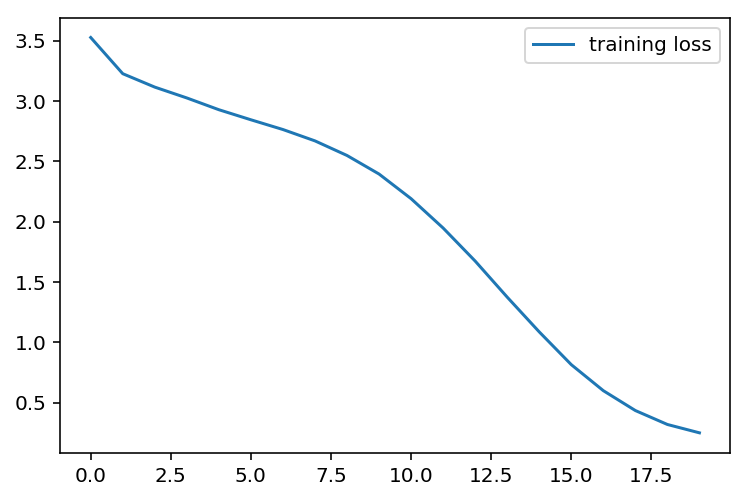

In [14]:
plt.plot(history.history['loss'])
plt.legend(['training loss'], loc='upper right')